# Modeling Distributions

The distributions we have used so far are called empirical distributions because they are based on empirical observations – in other words, data. Many datasets we see in the real world can be closely approximated by a theoretical distribution, which is usually based on a simple mathematical function. This chapter presents some of these theoretical distributions and datasets they can be used to model.

As examples, we’ll see that:

* In a skeet shooting competition, the number of hits and misses is well modeled by a binomial distribution.

* In games like hockey and soccer (football), the number of goals in a game follows a Poisson distribution, and the time between goals follows an exponential distribution.

* Birth weights follow a normal distribution, also called a Gaussian, and adult weights follow a lognormal distribution.

https://allendowney.github.io/ThinkStats/chap05.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nsfg import download

In [2]:
def two_bar_plots(ftab1, ftab2, label_1="Label 1", label_2="Label 2", width=0.45):
    ftab1.bar(align="edge", width=-width, label=label_1)
    ftab2.bar(align="edge", width=width, alpha=0.5, label=label_2)

## The Binomial Distribution

As a first example, we’ll consider the sport of skeet shooting, in which competitors use shotguns to shoot clay disks that are thrown into the air. In international competition, including the Olympics, there are five rounds with 25 targets per round, with additional rounds as needed to determine a winner.

As a model of a skeet-shooting competition, suppose that every participant has the same probability, p, of hitting every target. Of course, this model is a simplification – in reality, some competitors have a higher probability than others, and even for a single competitor, it might vary from one attempt to the next. But even if it is not realistic, this model makes some surprisingly accurate predictions, as we’ll see.

To simulate the model, I’ll use the following function, which takes the number of targets, n, and the probability of hitting each one, p, and returns a sequence of 1s and 0s to indicate hits and misses.

In [3]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p=probs)

In [4]:
np.random.seed(1)

In [5]:
flip(25, 0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1])

In [6]:
# Validate with Probability Mass Function
from empiricaldist import Pmf

seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,probs
0,0.101
1,0.899


In [7]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

In [8]:
# In a large competition, suppose 200 competitors shoot 5 rounds each, all with the same probability of hitting the target, p=0.9. 
# We can simulate a competition like that by calling simulate_round 1000 times.

n = 25
p = 0.9
results_sim = [simulate_round(n, p) for i in range(1000)]

In [9]:
np.mean(results_sim), n * p

(22.522, 22.5)

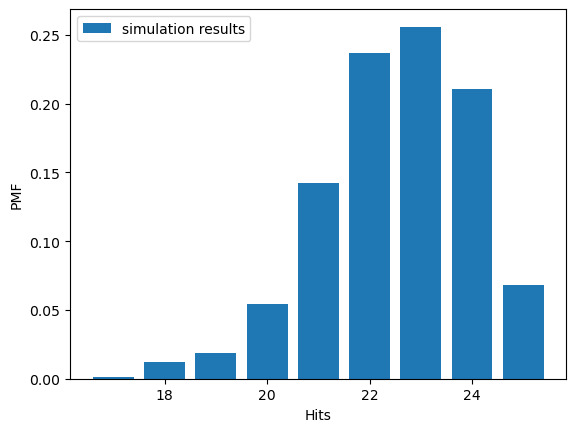

In [10]:
pmf_sim = Pmf.from_seq(results_sim, name="simulation results")

pmf_sim.bar()
plt.xlabel("Hits")
plt.ylabel("PMF")
plt.legend()
plt.show()

In [11]:
#The peak is near the mean, and the distribution is skewed to the left.

In [12]:
# Instead of running a simulation, we could have predicted this distribution. 
# Mathematically, the distribution of these outcomes follows a binomial distribution, which has a PMF that is easy to compute.

from scipy.special import comb


def binomial_pmf(k, n, p):
    """
    Binomial_pmf computes the probability of getting k hits out of n attempts, given p.
    If we call this function with a range of k values, we can make a Pmf that represents the distribution of the outcomes.
    """
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))

In [13]:
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

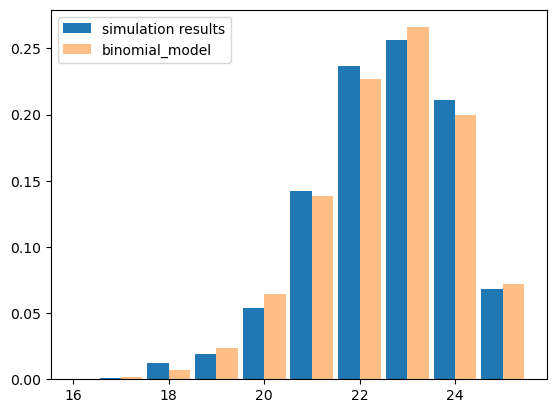

In [14]:
two_bar_plots(pmf_sim, pmf_binom, label_1="simulation results", label_2="binomial_model")

plt.legend()
plt.show()

### Download Summer Olympics Mens Data

In [15]:
path_to_download = "datasets/olympics/"
filename = "Shooting_at_the_2020_Summer_Olympics_Mens_skeet"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename, path=path_to_download)

In [16]:
tables = pd.read_html(path_to_download + filename)
table = tables[6]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


In [17]:
columns = ["1", "2", "3", "4", "5"]
results = table[columns].values.flatten()

In [18]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(25, 3750, 3575)

In [19]:
p = total_hits / total_shots
p #Overall Success Rate

0.9533333333333334

In [20]:
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

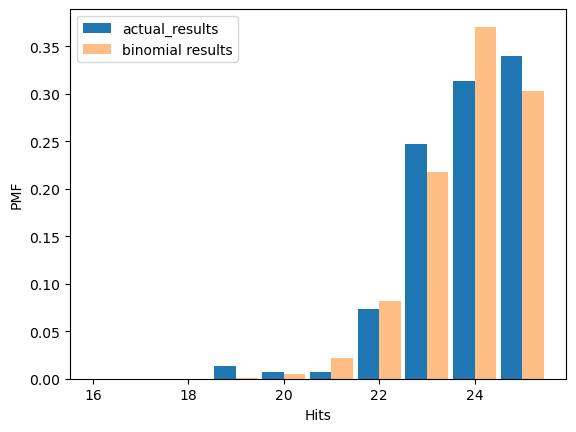

In [21]:
pmf_results = Pmf.from_seq(results, name="actual results")

two_bar_plots(pmf_results, pmf_binom, label_1="actual_results", label_2="binomial results")
plt.xlabel("Hits")
plt.ylabel("PMF")
plt.legend()
plt.show()

## The Poisson Distribution

As another example where the outcomes of sports events follow predictable patterns, let’s look at the number of goals scored in ice hockey games.

We’ll start by simulating a 60-minute game, which is 3600 seconds, assuming that the teams score a total of 6 goals per game, on average, and that the goal-scoring probability, p, is the same during any second.

In [22]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

In [23]:
def simulate_goals(n, p):
    return flip(n, p).sum()

In [24]:
goals = [simulate_goals(n, p) for i in range(1001)]
np.mean(goals)

6.021978021978022

We could use the binomial distribution to model these results, but when n is large and p is small, the results are also well-modeled by a **Poisson distribution**, which is specified by a value usually denoted with the Greek letter λ, which is pronounced “lambda” and represented in code with the variable lam (lambda is not a legal variable name because it is a Python keyword). lam represents the goal-scoring rate, which is 6 goals per game in the example.

The PMF of the Poisson distribution is easy to compute – given lam, we can use the following function to compute the probability of seeing k goals in a game.

In [25]:
from scipy.special import factorial


def poisson_pmf(k, lam):
    """Compute the Poisson PMF.

    k (int or array-like): The number of occurrences
    lam (float): The rate parameter (λ) of the Poisson distribution

    returns: float or ndarray
    """
    return (lam**k) * np.exp(-lam) / factorial(k)

#SciPy provides the factorial function, which computes the product of the integers from 1 to k. factorial(8) == 8!

In [26]:
lam = 6
ks = np.arange(20)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

In [27]:
pmf_poisson.normalize()
pmf_poisson.mean()

5.793429147092658

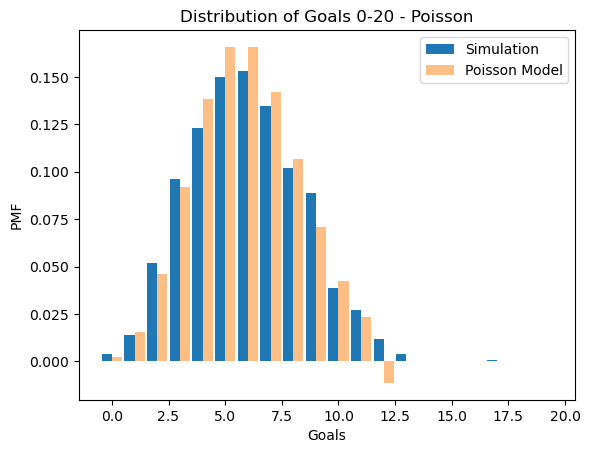

In [28]:
plt.title("Distribution of Goals 0-20 - Poisson")
pmf_sim = Pmf.from_seq(goals, name="simulation")

two_bar_plots(pmf_sim, pmf_poisson, label_1="Simulation", label_2="Poisson Model")
plt.xlabel("Goals")
plt.ylabel("PMF")
plt.legend()
plt.show()

### Download Hockey Reference Data

In [29]:
path_to_download = "datasets/hockey/"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nhl_2023_2024.hdf", path=path_to_download)

In [30]:
filename = path_to_download + "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

len(keys), keys[0]

(1312, '/202310100PIT')

In [31]:
times = pd.read_hdf(filename, key=keys[3])
times

0     337
1     682
2    1989
3    3544
dtype: int64

In [32]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

In [33]:
goals[:5]

[6, 8, 5, 4, 8]

In [34]:
lam = np.mean(goals)
lam

6.0182926829268295

In [35]:
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

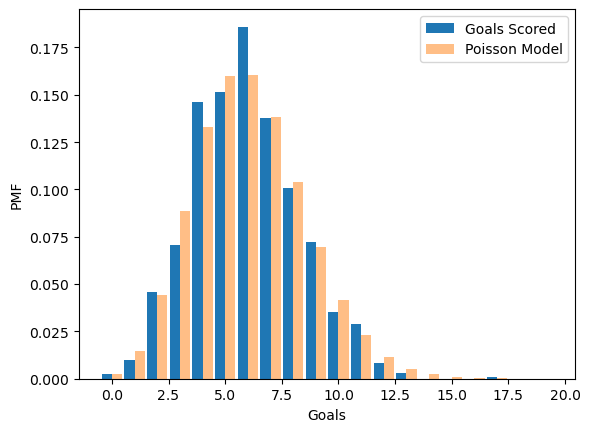

In [36]:
pmf_goals = Pmf.from_seq(goals, name="goals scored")

two_bar_plots(pmf_goals, pmf_poisson, label_1="Goals Scored", label_2="Poisson Model")

plt.xlabel("Goals")
plt.ylabel("PMF")
plt.legend()
plt.show()

## The Exponential Distribution

In the previous section, we simulated a simple model of a hockey game where a goal has the same probability of being scored during any second of the game. Under the same model, it turns out, the time until the first goal follows an exponential distribution.

To demonstrate, let’s assume again that the teams score a total of 6 goals, on average, and compute the probability of a goal during each second.

In [37]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

In [38]:
#The following function simulates n seconds and uses argmax to find the time of the first goal.

def simulate_first_goal(n, p):
    return flip(n, p).argmax()

In [39]:
np.random.seed(3)

In [40]:
first_goal_times = [simulate_first_goal(n, p) for i in range(1001)]
mean = np.mean(first_goal_times)
mean

597.7902097902098

When n is large and p is small, we can show mathematically that the expected time until the first goal follows an exponential distribution.

Because the simulation generates many unique time values, we’ll use CDFs to compare distributions, rather than PMFs. And the CDF of the exponential distribution is easy to compute.

In [41]:
def exponential_cdf(x, lam):
    """Compute the exponential CDF.

    x: float or sequence of floats
    lam: rate parameter

    returns: float or NumPy array of cumulative probability
    """
    return 1 - np.exp(-lam * x)

In [42]:
lam = 1 / mean
lam

0.0016728276636563566

In [43]:
from empiricaldist import Cdf

ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

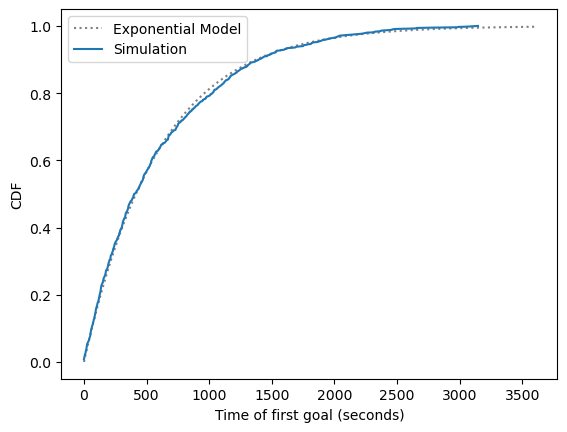

In [44]:
cdf_sim = Cdf.from_seq(first_goal_times, name="simulation")

cdf_expo.plot(ls=":", color="gray", label="Exponential Model")
cdf_sim.plot(label="Simulation")

plt.xlabel("Time of first goal (seconds)")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [45]:
firsts = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)

In [46]:
# Ignoring NaN-s
lam = 1 / np.nanmean(firsts)
lam

0.0015121567467720825

In [47]:
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

In [48]:
cdf_firsts = Cdf.from_seq(firsts, name="data", dropna=False)
cdf_firsts.tail()

,probs
3286.0,0.996951
3581.0,0.997713
NaN,1.000000


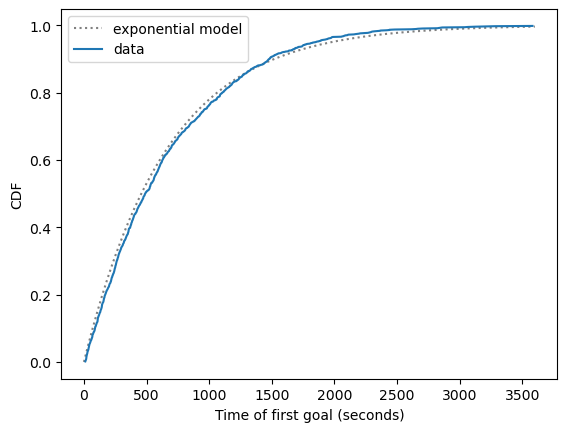

In [49]:
cdf_expo.plot(ls=":", color="gray")
cdf_firsts.plot()

plt.xlabel("Time of first goal (seconds)")
plt.ylabel("CDF")
plt.legend()
plt.show()

The data deviate from the model in some places – it looks like there are fewer goals in the first 1000 seconds than the model predicts. But still, the model fits the data well.

The underlying assumption of these models – the Poisson model of goals and the exponential model of times – is that a goal is equally likely during any second of a game. If you ask a hockey fan whether that’s true, they would say no, and they would be right – the real world violates assumptions like these in many ways. Nevertheless, theoretical distributions often fit real data remarkably well.

## The Normal Distribution

Many things we measure in the real world follow a normal distribution, also known as a Gaussian distribution or a “bell curve”. To see where these distributions come from, let’s consider a model of the way giant pumpkins grow. Suppose that each day, a pumpkin gains 1 pound if the weather is bad, 2 pounds if the weather is fair, and 3 pounds if the weather is good. And suppose the weather each day is bad, fair, or good with the same probability.

We can use the following function to simulate this model for n days and return the total of the weight gains.

In [50]:
def simulate_growth(n):
    choices = [1, 2, 3]
    gains = np.random.choice(choices, n)
    return gains.sum()

Now suppose 1001 people grow giant pumpkins in different places with different weather. If we simulate the growth process for 100 days, we get a list of 1001 weights.

In [51]:
sim_weights = [simulate_growth(100) for i in range(1001)]
m, s = np.mean(sim_weights), np.std(sim_weights)
m, s

(199.37062937062936, 8.388630840376777)

The mean is close to 200 pounds and the standard deviation is about 8 pounds. To see whether the weights follow a normal distribution, we’ll use the following function, which takes a sample and makes a Cdf that represents a normal distribution with the same mean and standard deviation as the sample, evaluated over the range from 4 standard deviations below the mean to 4 standard deviations above.

In [52]:
from scipy.stats import norm


def make_normal_model(data):
    m, s = np.mean(data), np.std(data)
    low, high = m - 4 * s, m + 4 * s
    qs = np.linspace(low, high, 201)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs, name="normal model")

In [53]:
cdf_model = make_normal_model(sim_weights)

In [54]:
cdf_sim_weights = Cdf.from_seq(sim_weights, name="simulation")

In [93]:
def two_cdf_plots(cdf_model, cdf_data, xlabel="", **options):
    cdf_model.plot(ls=":", color="gray")
    cdf_data.plot(**options)
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel="CDF")
    plt.legend()
    plt.show()

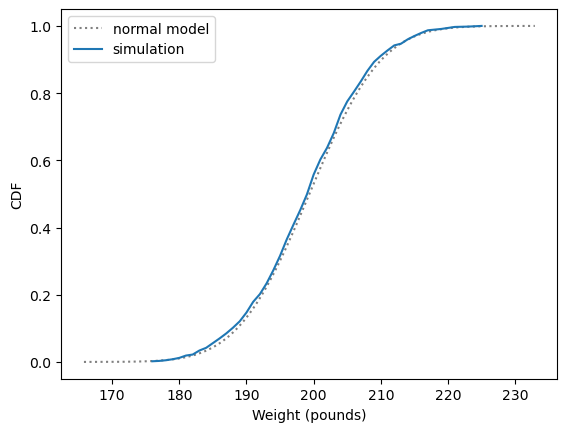

In [56]:
two_cdf_plots(cdf_model, cdf_sim_weights, xlabel="Weight (pounds)")

The normal model fits the distribution of the weights very well. In general, when we add up enough random factors, the sum tends to follow a normal distribution. That’s a consequence of the Central Limit Theorem, which we’ll come back to in Chapter 14.

### Import NSFG Data

In [57]:
import statadict
import nsfg
from scipy.stats import trimboth


preg = nsfg.read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

In [58]:
m, s = np.mean(birth_weights), np.std(birth_weights)
m, s

(7.265628457623368, 1.4082155338406195)

In [59]:
trimmed = trimboth(birth_weights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(7.280883100022579, 1.2430657948614345)

In [60]:
cdf_model = make_normal_model(trimmed)

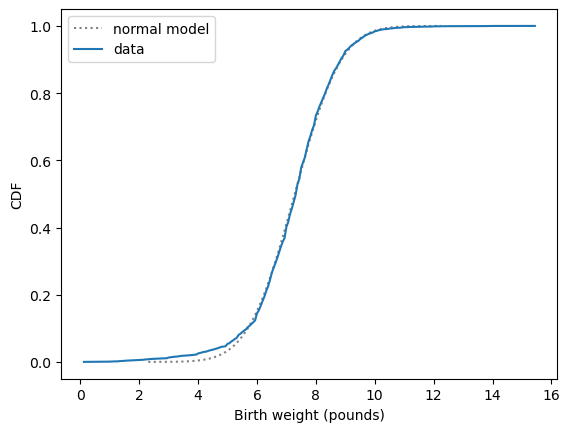

In [61]:
cdf_birth_weight = Cdf.from_seq(birth_weights, name='data')

two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

## The Lognormal Distribution

In the previous section, we simulated pumpkin growth under the assumption that pumpkins grow 1-3 pounds per day, depending on the weather. Instead, let’s suppose their growth is proportional to their current weight, so big pumpkins gain more weight per day than small pumpkins – which is probably more realistic.

The following function simulates this kind of proportional growth, where a pumpkin gains 3% of its weight if the weather is bad, 5% if the weather is fair, and 7% if the weather is good. Again, we’ll assume that the weather is bad, fair, or good on any given day with equal probability.

In [62]:
def simulate_proportionate_growth(n):
    choices = [1.03, 1.05, 1.07]
    gains = np.random.choice(choices, n)
    return gains.prod()

If a pumpkin gains 3% of its weight, the final weight is the product of the initial weight and the factor 1.03. So we can compute the weight after 100 days by choosing random factors and multiplying them together.

We’ll call this function 1001 times to simulate 1001 pumpkins and save their weights.

In [63]:
sim_weights = [simulate_proportionate_growth(100) for i in range(1001)]
np.mean(sim_weights), np.std(sim_weights)

(130.80183363824722, 20.956047434921466)

The average weight is about 131 pounds; the standard deviation is about 21 pounds. So the pumpkins in this model are smaller but more variable than in the previous model.

And we can show mathematically that they follow a lognormal distribution, which means that the **logarithms of the weights follow a normal distribution**. To check, we’ll compute the logs of the weights and their mean and standard deviation. We could use logarithms with any base, but I’ll use base 10 because it makes the results easier to interpret.

In [64]:
log_sim_weights = np.log10(sim_weights)
m, s = np.mean(log_sim_weights), np.std(log_sim_weights)
m, s

(2.1111299372609933, 0.06898607064749827)

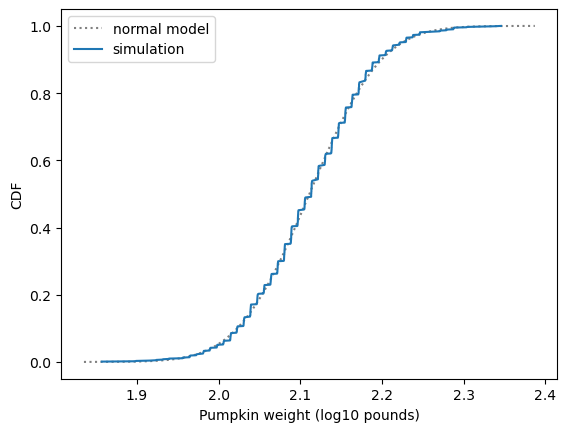

In [65]:
cdf_model = make_normal_model(log_sim_weights)
cdf_log_sim_weights = Cdf.from_seq(log_sim_weights, name="simulation")

two_cdf_plots(
    cdf_model, cdf_log_sim_weights, xlabel="Pumpkin weight (log10 pounds)"
)

### BRFSS Data

In [66]:
#download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz", path="datasets/brfss/")

In [67]:
from thinkstats import read_brfss

brfss = read_brfss()

In [68]:
brfss.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


In [69]:
adult_weights = brfss["wtkg2"].dropna()
m, s = np.mean(adult_weights), np.std(adult_weights)
m, s

(78.9924529968581, 19.54613238740293)

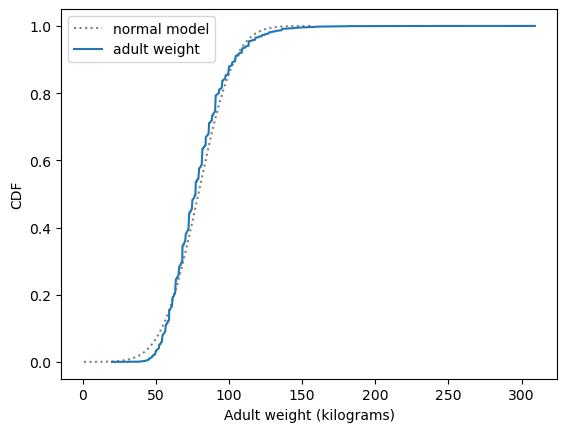

In [70]:
cdf_model = make_normal_model(adult_weights)
cdf_adult_weights = Cdf.from_seq(adult_weights, name="adult weight")

two_cdf_plots(cdf_model, cdf_adult_weights, xlabel="Adult weight (kilograms)")

In [71]:
log_adult_weights = np.log10(adult_weights)
cdf_model = make_normal_model(log_adult_weights)

cdf_log_adult_weights = Cdf.from_seq(log_adult_weights, name="log adult weight")

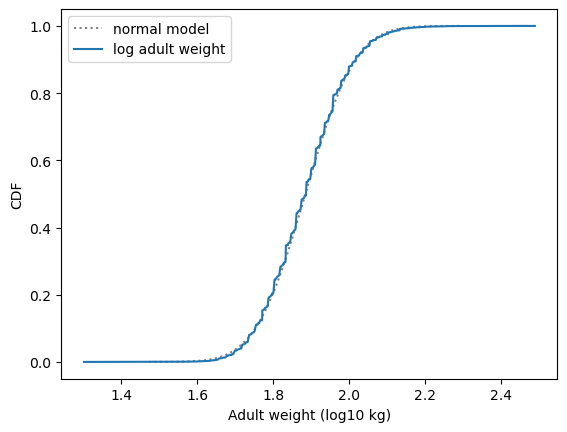

In [72]:
two_cdf_plots(cdf_model, cdf_log_adult_weights, xlabel="Adult weight (log10 kg)")

The normal model fits the logarithms better than it fits the weights themselves, which suggests that proportional growth is a better model of weight gain than additive growth.

## Why model?

At the beginning of this chapter, I said that many real world phenomena can be modeled with theoretical distributions. But it might not have been clear why we should care.

Like all models, theoretical distributions are abstractions, which means they leave out details that are considered irrelevant. For example, an observed distribution might have measurement errors or quirks that are specific to the sample; theoretical models ignore these idiosyncrasies.

Theoretical models are also a form of data compression. When a model fits a dataset well, a small set of numbers can summarize a large amount of data.

It is sometimes surprising when data from a natural phenomenon fit a theoretical distribution, but these observations can provide insight into physical systems. Sometimes we can explain why an observed distribution has a particular form. For example, in the previous section we found that adult weights are well-modeled by a lognormal distribution, which suggests that changes in weight from year to year might be proportional to current weight.

Also, theoretical distributions lend themselves to mathematical analysis, as we’ll see in Chapter 14.

But it is important to remember that all models are imperfect. Data from the real world never fit a theoretical distribution perfectly. People sometimes talk as if data are generated by models; for example, they might say that the distribution of human heights is normal, or the distribution of income is lognormal. Taken literally, these claims cannot be true – there are always differences between the real world and mathematical models.

Models are useful if they capture the relevant aspects of the real world and leave out unneeded details. But what is relevant or unneeded depends on what you are planning to use the model for.

## Glossary

* binomial distribution: A theoretical distribution often used to model the number of successes or hits in a sequence of hits and misses.

* Poisson distribution: A theoretical distribution often used to model the number of events that occur in an interval of time.

* exponential distribution: A theoretical distribution often used to model the time between events.

* normal distribution: A theoretical distribution often used to model data that follow a symmetric, bell-like curve.

* lognormal distribution: A theoretical distribution often used to model data that follow a bell-like curve that is skewed to the right.

## Exercise 5.1

In the NSFG respondent file, the numfmhh column records the “number of family members in” each respondent’s household. We can use read_fem_resp to read the file, and query to select respondents who were 25 or older when they were interviewed.

In [73]:
from nsfg import read_fem_resp

In [74]:
resp = read_fem_resp()

In [75]:
older = resp.query("age >= 25")
num_family = older["numfmhh"]

In [76]:
pmf_data = Pmf.from_seq(num_family, name="Number of family members")

In [77]:
pmf_data

,probs
numfmhh,
0,0.118334
1,0.229272
2,0.239587
3,0.231608
4,0.120475
5,0.039510
6,0.013429
7,0.007785


In [78]:
np.mean(num_family), np.std(num_family)

(2.2177890229661346, 1.4607418839607762)

In [79]:
lam = 2 # mean of num_family
ks = np.arange(7)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

In [80]:
pmf_poisson.normalize()
pmf_poisson.mean()

1.9758308157099695

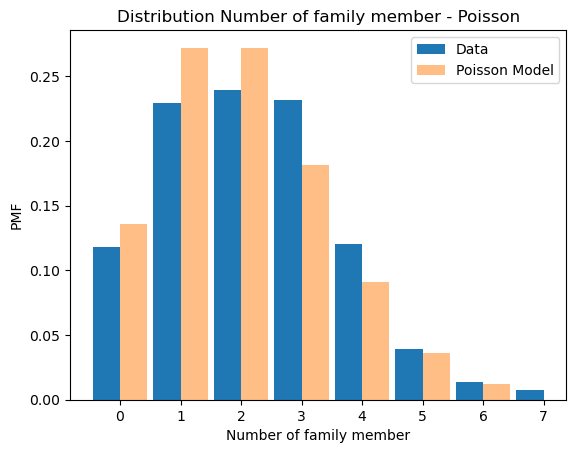

In [81]:
plt.title("Distribution Number of family member - Poisson")

two_bar_plots(pmf_data, pmf_poisson, label_1="Data", label_2="Poisson Model")
plt.xlabel("Number of family member")
plt.ylabel("PMF")
plt.legend()
plt.show()

## Exercise 5.2

Earlier in this chapter we saw that the time until the first goal in a hockey game follows an exponential distribution. If our model of goal-scoring is correct, a goal is equally likely at any time, regardless of how long it has been since the previous goal. And if that’s true, we expect the time between goals to follow an exponential distribution, too.

The following loop reads the hockey data again, computes the time between successive goals, if there is more than one in a game, and collects the inter-goal times in a list.

Use exponential_cdf to compute the CDF of an exponential distribution with the same mean as the observed intervals and compare this model to the CDF of the data.

In [82]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 1:
        intervals.extend(times.diff().dropna())

In [83]:
intervals[:3]

[1492.0, 221.0, 868.0]

In [84]:
# Ignoring NaN-s
lam = 1 / np.nanmean(intervals)
lam

0.002040836560191201

In [85]:
ts = np.linspace(0, 3000, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

In [86]:
cdf_intervals = Cdf.from_seq(intervals, name="data", dropna=False)
cdf_intervals.tail()

,probs
2934.0,0.999696
2992.0,0.999848
3007.0,1.000000


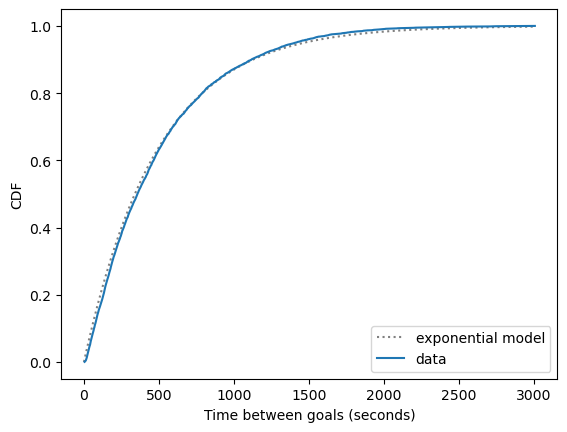

In [87]:
cdf_expo.plot(ls=":", color="gray")
cdf_intervals.plot()

plt.xlabel("Time between goals (seconds)")
plt.ylabel("CDF")
plt.legend()
plt.show()

## Exercise 5.3

Is the distribution of human height more like a normal or a lognormal distribution? To find out, we can select height data from the BRFSS like this:

In [88]:
adult_heights = brfss["htm3"].dropna()
m, s = np.mean(adult_heights), np.std(adult_heights)
m, s

(168.82518961012298, 10.352640156457166)

Compute the CDF of these values and compare it to a normal distribution with the same mean and standard deviation. Then compute the logarithms of the heights and compute the distribution of the logarithms to a normal distribution. Based on a visual comparison, which model fits the data better?

In [89]:
log_adult_heights = np.log10(adult_heights)

In [90]:
cdf_data_normal = make_normal_model(adult_heights)
cdf_data_lognormal = make_normal_model(log_adult_heights)

In [97]:
cdf_heights = Cdf.from_seq(adult_heights, name="Data")
cdf_log_heights = Cdf.from_seq(log_adult_heights, name="simulation")

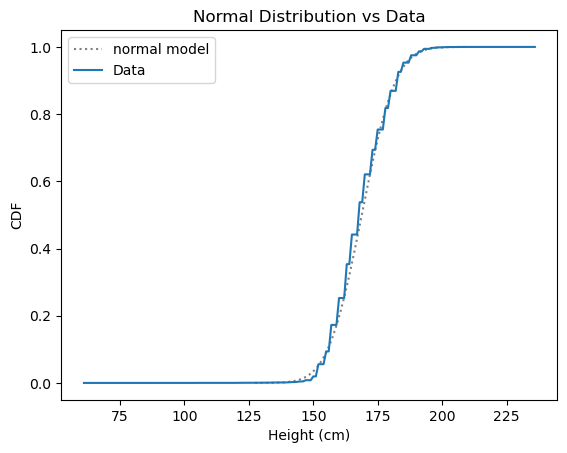

In [98]:
plt.title("Normal Distribution vs Data")
two_cdf_plots(cdf_data_normal, cdf_heights, xlabel="Height (cm)")
plt.show()

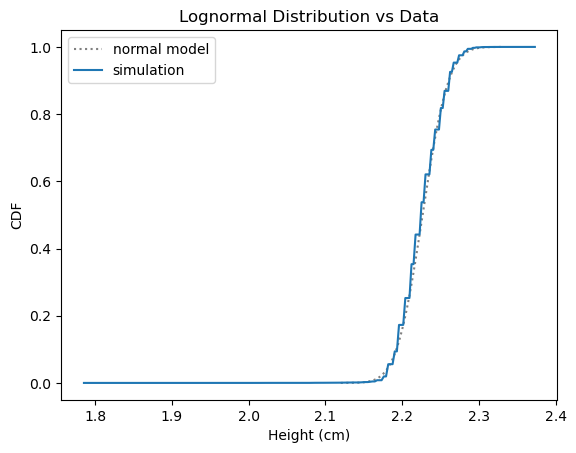

In [100]:
plt.title("Lognormal Distribution vs Data")

two_cdf_plots(cdf_data_lognormal, cdf_log_heights, xlabel="Height (cm)")
plt.show()